In [17]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 64

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/mnt/data/IVF/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Compacting    2430
Blastocyst    2246
2pn           2015
Empty         1423
Syngamy       1174
2 Cell        1087
4 Cell         951
8 Cell         469
6 Cell         446
3 Cell         374
9 Cell+        244
5 Cell         215
Name: class, dtype: int64

<AxesSubplot:>

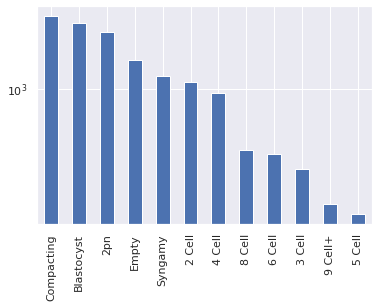

In [18]:
df["class"].value_counts().plot.bar(logy=True)

In [19]:
class_counts = df["class"].value_counts()
#mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [20]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),500))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),2000))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/mnt/data/IVF/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_6706.jpg,9 Cell+
1,/mnt/data/IVF/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W1_F0_3943.jpg,9 Cell+
2,/mnt/data/IVF/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W1_F0_4476.jpg,9 Cell+
3,/mnt/data/IVF/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_5487.jpg,9 Cell+
4,/mnt/data/IVF/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_5187.jpg,9 Cell+
...,...,...
1082,/mnt/data/IVF/EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
1083,/mnt/data/IVF/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00668_W15_F0_1977.jpg,2 Cell
1084,/mnt/data/IVF/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00668_W7_F0_1755.jpg,2 Cell
1085,/mnt/data/IVF/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Compacting    1944
Blastocyst    1797
2pn           1612
Empty         1138
Syngamy        939
2 Cell         870
4 Cell         761
8 Cell         375
6 Cell         357
3 Cell         299
9 Cell+        195
5 Cell         172
Name: class, dtype: int64

Compacting    486
Blastocyst    449
2pn           403
Empty         285
Syngamy       235
2 Cell        217
4 Cell        190
8 Cell         94
6 Cell         89
3 Cell         75
9 Cell+        49
5 Cell         43
Name: class, dtype: int64

In [21]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


training = datagen.flow_from_dataframe(train_df, target_size=(456, 456), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(456, 456), batch_size=BATCH_SIZE, shuffle=False)

Found 10459 validated image filenames belonging to 12 classes.
Found 2615 validated image filenames belonging to 12 classes.


In [22]:
assert training.class_indices == validation.class_indices

In [23]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 '9 Cell+',
 'Blastocyst',
 'Compacting',
 'Empty',
 'Syngamy']

In [24]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: '9 Cell+',
 8: 'Blastocyst',
 9: 'Compacting',
 10: 'Empty',
 11: 'Syngamy'}

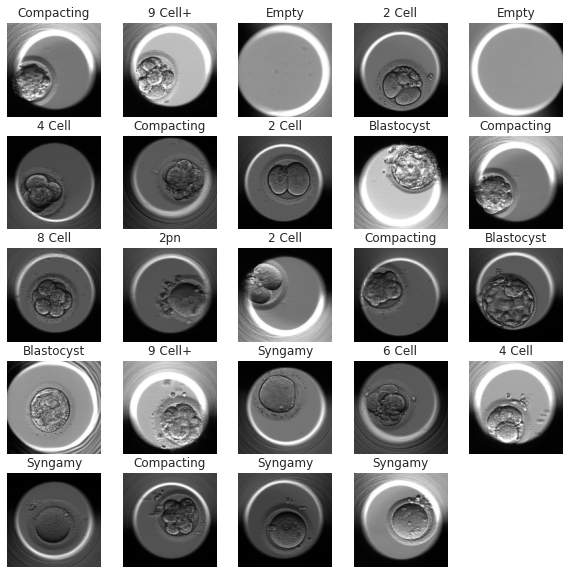

In [25]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

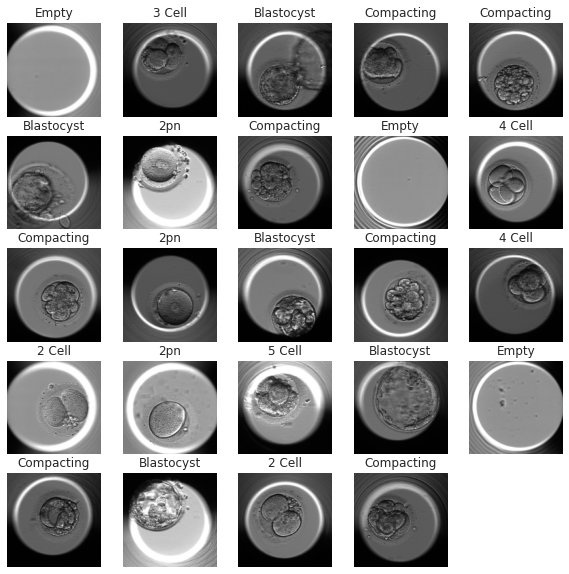

In [26]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [27]:

base_enetb5 = keras.applications.EfficientNetB5(
    weights='imagenet',
    input_shape=(456,456,3),
    include_top=False
)
# Freeze the base_model
base_enetb5.trainable = False

# Create new model on top
inputs = keras.Input(shape=(456, 456, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_enetb5(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 456, 456, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 456, 456, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                           

In [28]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 14.3 ms


In [29]:

history = model.fit(training,
                    epochs=500,
                    verbose=1, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='loss',patience=30, verbose=1),
                    ])

Epoch 1/500


2022-06-27 10:11:44.867784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-06-27 10:11:45.851451: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


164/164 [==============================] - 130s 705ms/step - loss: 2.0154 - categorical_accuracy: 0.3400 - val_loss: 1.8715 - val_categorical_accuracy: 0.4203
Epoch 2/500
164/164 [==============================] - 111s 671ms/step - loss: 1.7544 - categorical_accuracy: 0.4559 - val_loss: 1.7316 - val_categorical_accuracy: 0.4872
Epoch 3/500
164/164 [==============================] - 110s 669ms/step - loss: 1.6356 - categorical_accuracy: 0.5122 - val_loss: 1.5367 - val_categorical_accuracy: 0.5553
Epoch 4/500
164/164 [==============================] - 110s 671ms/step - loss: 1.5793 - categorical_accuracy: 0.5334 - val_loss: 1.4981 - val_categorical_accuracy: 0.5667
Epoch 5/500
164/164 [==============================] - 110s 671ms/step - loss: 1.5377 - categorical_accuracy: 0.5519 - val_loss: 1.4747 - val_categorical_accuracy: 0.5400
Epoch 6/500
164/164 [==============================] - 110s 669ms/step - loss: 1.4898 - categorical_accuracy: 0.5723 - val_loss: 1.6228 - val_categorical_acc

<AxesSubplot:>

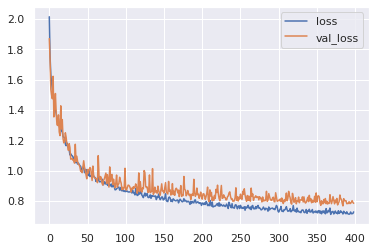

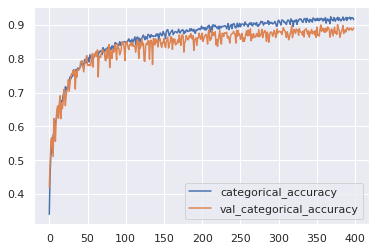

In [30]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [31]:
y_pred = model.predict(validation)

41/41 [==============================] - 25s 528ms/step


In [32]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    2615.000000
mean        0.812626
std         0.152650
min         0.166608
25%         0.761362
50%         0.881478
75%         0.909897
max         0.991528
dtype: float64

In [37]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df
validation_df.to_csv("predictions.csv", index=False)

In [34]:
validation_df.groupby("class").confidence.median()

class
2 Cell        0.874566
2pn           0.878990
3 Cell        0.872466
4 Cell        0.870086
5 Cell        0.841303
6 Cell        0.875540
8 Cell        0.870408
9 Cell+       0.871639
Blastocyst    0.888355
Compacting    0.878958
Empty         0.878992
Syngamy       0.890678
Name: confidence, dtype: float32

              precision    recall  f1-score   support

      2 Cell       0.90      0.83      0.86       217
         2pn       0.84      0.94      0.89       403
      3 Cell       0.86      0.72      0.78        75
      4 Cell       0.93      0.81      0.87       190
      5 Cell       0.67      0.67      0.67        43
      6 Cell       0.86      0.61      0.71        89
      8 Cell       0.77      0.67      0.72        94
     9 Cell+       0.92      0.96      0.94        49
  Blastocyst       0.95      0.98      0.96       449
  Compacting       0.86      0.94      0.90       486
       Empty       1.00      1.00      1.00       285
     Syngamy       0.84      0.77      0.81       235

    accuracy                           0.89      2615
   macro avg       0.87      0.83      0.84      2615
weighted avg       0.89      0.89      0.89      2615



Text(30.5, 0.5, 'True')

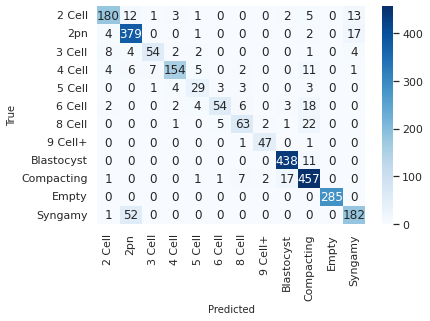

In [35]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [39]:
model.save(f"/mnt/data/IVF/models/b5_dense_{len(code2class)}_class.h5")